In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import imageio
import pickle
import cv2

from skimage.transform import rescale, resize, rotate
from skimage.color import rgb2gray
from sklearn.metrics import confusion_matrix, auc, accuracy_score
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, SGD
from keras import callbacks
from keras.models import load_model
from keras import models

import warnings
warnings.filterwarnings("ignore")

random_state = 42


np.random.seed(random_state)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Resume Supporting Material /Personal Projects/Varroa Mite Bee Detector /bee_data.csv"
raw_data = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
raw_data.shape

(5172, 9)

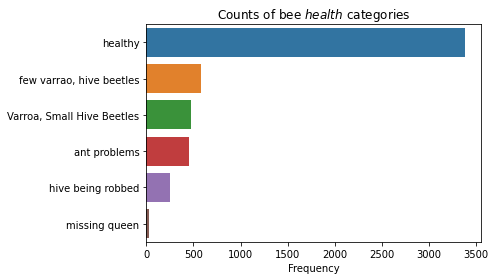

In [ ]:
health_counts = raw_data["health"].value_counts()

plt.title("Counts of bee $health$ categories")
g = sns.barplot(x = health_counts, y = health_counts.index);
g.set_xlabel("Frequency");

In [ ]:
target_categories = [name for name in health_counts.index if "varr" in name.lower() or "health" in name.lower()]
raw_data = raw_data[[status in target_categories for status in raw_data["health"]]]
raw_data["has_varroa"] = (raw_data["health"] != "healthy").astype(int)

In [ ]:
raw_data.shape

(4435, 10)

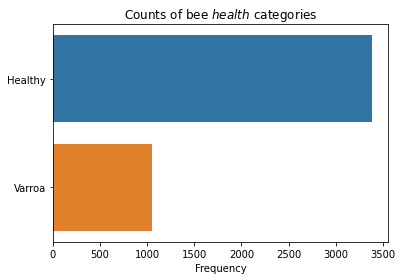

In [ ]:
health_counts = raw_data["has_varroa"].value_counts()

plt.title("Counts of bee $health$ categories")
g = sns.barplot(x = health_counts, y = health_counts.index, orient="h");
plt.yticks([0,1],["Healthy","Varroa"])
g.set_xlabel("Frequency");

In [ ]:
raw_data.groupby("location").mean()[["has_varroa"]]

,has_varroa
location,
"Athens, GA, USA",1
"Athens, Georgia, USA",1
"Des Moines, IA, USA",0
"Keene, NH, USA",0
"New Orleans, LA, USA",0
"San Jose, CA, USA",0
"Saratoga, CA, USA",0


In [ ]:
raw_data[raw_data["has_varroa"] == 1]["subspecies"].value_counts()

Italian honey bee        579
1 Mixed local stock 2    472
Name: subspecies, dtype: int64

In [ ]:
data = raw_data[["file","has_varroa"]]
data.head(2)

,file,has_varroa
74,017_029.png,0
75,017_015.png,0


In [ ]:
data["has_varroa"].value_counts(normalize = True)

0    0.763021
1    0.236979
Name: has_varroa, dtype: float64

In [ ]:
row_images = cv2.imread('/content/drive/MyDrive/archive/bee_imgs')

In [ ]:
def get_images_wh(images):
    
    widths = []
    heights = []
    for image in images:
        h, w, rbg = image.shape
        widths.append(w)
        heights.append(h)
    return (widths, heights)

In [ ]:
def get_best_average(dist, cutoff = .5):
    # requires single peak normal-like distribution
    hist, bin_edges = np.histogram(dist, bins = 25);
    total_hist = sum(hist)
    
    # associating proportion of hist with bin_edges
    hist_edges = [(vals[0]/total_hist,vals[1]) for vals in zip(hist, bin_edges)]
    
    # sorting by proportions (assumes normal-like dist such that high freq. bins are close together)
    hist_edges.sort(key = lambda x: x[0])
    lefts = []
    
    # add highest freq. bins to list up to cutoff % of total
    while cutoff > 0:
        vals = hist_edges.pop()
        cutoff -= vals[0]
        lefts.append(vals[1])
        
    # determining leftmost and rightmost range, then returning average
    diff = np.abs(np.diff(lefts)[0]) # same diff b/c of bins
    leftmost = min(lefts)
    rightmost = max(lefts) + diff
    return int(np.round(np.mean([rightmost,leftmost])))

In [ ]:
def normalize(image):
    
    return (image/255. - 0.5)

In [ ]:
def create_datagens(
    data, datagen_params, 
    target_shape, batch_size, x_col="file", y_col="has_varroa", IMAGE_FILE_ROOT = '/content/drive/MyDrive/archive/bee_imgs', 
    random_state = None, preprocessing_function = None):
        
        data[y_col] = data[y_col].astype(str) # coercion needed for datagen
        # train/test split
        train, test = train_test_split(
            data, 
            test_size = 1/3, 
            stratify = data.iloc[:,-1], # assumed last column is target variable
            random_state = random_state
            )
        
        # training ImageDataGenerator
        datagen = ImageDataGenerator(
            horizontal_flip  = datagen_params.get("horizontal_flip") or False, 
            vertical_flip    = datagen_params.get("vertical_flip") or False, 
            rotation_range   = datagen_params.get("rotation_range") or False,
            brightness_range = datagen_params.get("brightness_range"),
            preprocessing_function = preprocessing_function
        )

        datagen_iter_train = datagen.flow_from_dataframe(
            train, 
            directory   = IMAGE_FILE_ROOT, 
            x_col       = x_col,
            y_col       = y_col,
            target_size = target_shape, 
            color_mode  = 'rgb', 
            class_mode  = 'binary', 
            batch_size  = batch_size, 
            shuffle     = True,
            seed        = random_state
        )

        # testing ImageDataGenerator
        datagen_test = ImageDataGenerator(preprocessing_function = preprocessing_function)

        datagen_iter_test = datagen_test.flow_from_dataframe(
            test, 
            directory   = IMAGE_FILE_ROOT, 
            x_col       = x_col,
            y_col       = y_col,
            target_size = target_shape, 
            color_mode  = 'rgb', 
            class_mode  = 'binary', 
            batch_size  = 1, 
            shuffle     = False
        )
        
        return datagen_iter_train, datagen_iter_test

In [ ]:
def permutate_params(grid_params):
    
    out = [{}]
    
    # loop through each key/val pair
    for param_name, param_list in grid_params.items():
        # shortcircut - no need to permute single items
        if len(param_list) == 1:
            for item in out:
                item[param_name] = param_list[0]
        else:
            temp_out = []
            # for each item in the param, clone entire growing list and add param to each
            for param_val in param_list:
                for item in out:
                    cloned_item = item.copy()
                    cloned_item[param_name] = param_val
                    temp_out.append(cloned_item)
            out = temp_out
    return out

In [ ]:
def build_model_from_datagen(
    params = dict(), 
    input_shape = (), 
    datagen_iter_train = None, 
    datagen_iter_val = None, 
    optimizer = "adam",
    file_name = None
):
    kernel_size = 3
    dropout = .5
    activation_func = "relu"

    conv__filters_1 = params.get('conv__filters_1') or 32
    conv__filters_2 = params.get('conv__filters_2') or 16
    conv__filters_3 = params.get('conv__filters_3') or 32
    density_units_1 = params.get('density_units_1') or 32
    density_units_2 = params.get('density_units_2') or 32
    epochs          = params.get('epochs') or 8
    
    # instantiating model
    model = Sequential([
        # Conv layer #1
        Conv2D(
            filters = conv__filters_1, 
            kernel_size = kernel_size + 4, 
            activation  = activation_func, 
            input_shape = input_shape, #input layer
            padding     = "same"
        ),
        Conv2D(filters = conv__filters_1, kernel_size = kernel_size + 4, activation = activation_func, padding = "same"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(dropout/2),

        # Conv layer #2
        Conv2D(filters = conv__filters_2, kernel_size = kernel_size + 2, activation=activation_func, padding = "same"),
        Conv2D(filters = conv__filters_2, kernel_size = kernel_size + 2, activation = activation_func, padding = "same"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(dropout/2),

        # Conv layer #3
        Conv2D(filters = conv__filters_3, kernel_size = kernel_size, activation=activation_func, padding = "same"),
        Conv2D(filters = conv__filters_3, kernel_size = kernel_size, activation = activation_func, padding = "same"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(dropout/2),

        # Dense layer #1
        Flatten(),
        Dense(density_units_1, activation=activation_func),
        Dropout(dropout),
        
        # Dense layer #2
        Dense(density_units_2, activation=activation_func),
        Dropout(dropout),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    # compiling model
    model.compile(
        loss      = 'binary_crossentropy',
        optimizer = optimizer,
        metrics   = ['binary_accuracy']
    )
    
    # fitting model w/ImageDataGenerator
    STEP_SIZE_TRAIN= np.ceil(datagen_iter_train.n/datagen_iter_train.batch_size)
    STEP_SIZE_VALID= np.ceil(datagen_iter_val.n/datagen_iter_val.batch_size)

    # NOTE: the best model is saved to disk via callbacks, and is a retrievable file
    history = model.fit_generator(
        generator           = datagen_iter_train,
        steps_per_epoch     = STEP_SIZE_TRAIN,
        validation_data     = datagen_iter_val,
        validation_steps    = STEP_SIZE_VALID,
        epochs              = epochs,
        callbacks           = [callbacks.ModelCheckpoint(file_name, save_best_only=True, mode='auto', period=1)]
    )
    
    return (model, history)

In [ ]:
def gridSearchCNN(
    datagens,
    grid_params, 
    file_name,
    optimizer = "adam",
    random_state = None,
):
    
    # list of all parameter combinations
    all_params = permutate_params(grid_params) 
    
    # establishing variables
    best_model   = None
    best_score   = 0.0 # no accuracy to start
    best_params  = None
    best_history = None
    test_scores  = None
    train_scores = None
    
    datagen_iter_train, datagen_iter_test = datagens
    
    # for each permuted parameter, try fitting a model (NOTE: the best model is saved to disk with file_name)
    for params in all_params:
        model, history = build_model_from_datagen(
            params, 
            input_shape        = datagen_iter_train.image_shape,
            datagen_iter_train = datagen_iter_train,
            datagen_iter_val   = datagen_iter_test,
            optimizer          = optimizer,
            file_name          = file_name
        )

        acc = max(history.history["val_binary_accuracy"])
        
        # only keeping best
        if acc > best_score:
            print("***Good Accurary found: {:.2%}***".format(acc))
            best_score   = acc
            test_scores  = history.history["val_binary_accuracy"]
            train_scores = history.history["binary_accuracy"]
            best_model   = model
            best_params  = params
            best_history = history
    
    # returns metadata of results (NOTE: retrieving best model from hard disk)
    return {
        "best_model"   : load_model(file_name),
        "best_score"   : best_score,
        "best_params"  : best_params,
        "best_history" : best_history,
        "test_scores"  : test_scores,
        "train_scores" : train_scores
    }

In [ ]:
def conf_matrix_stats(y_test, preds):
    
    cm = confusion_matrix(y_test, preds)
    TP, FP, FN, TN, = cm[1,1], cm[0,1], cm[1,0], cm[0,0]
    total = (TP + FP + FN + TN)
    acc = (TP + TN ) / total
    miss = 1 - acc
    sens = TP / (TP + FN)
    spec = TN / (TN + FP)
    prec = TP / (TP + FP)
    return {"accuracy": acc, "miss_rate": miss, "sensitivity": sens, "specification": spec, "precision": prec}

In [ ]:
def graph_loss(history):
    
    # Check out our train loss and test loss over epochs.
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    xticks = np.array(range(len(train_loss)))
    # Set figure size.
    plt.figure(figsize=(12, 8))

    # Generate line plot of training, testing loss over epochs.
    plt.plot(train_loss, label='Training Loss', color='#185fad')
    plt.plot(test_loss, label='Testing Loss', color='orange')

    # Set title
    plt.title('Training and Testing Loss by Epoch', fontsize = 25)
    plt.xlabel('Epoch', fontsize = 18)
    plt.ylabel('Binary Crossentropy', fontsize = 18)
    plt.xticks(xticks[::5], (xticks+1)[::5])

    plt.legend(fontsize = 18);

In [ ]:
def show_results(images, shapes, title, ncols = 4, height = 2, width = 2):
    
    nrows = int(np.ceil(len(images)/ncols))
    f, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=(ncols * width, nrows * height))
    ax = ax.flatten() if type(ax) == np.ndarray else ax
    i = None
    for i, image in enumerate(images):
        _title = f"Orig. size: {shapes[i][0]}x{shapes[i][1]}\n{title} #{i+1}"
        show_image(image, ax = ax[i] if type(ax) == np.ndarray else ax, title = _title)
    
    # removing extraneous subplots
    while i and type(ax) == np.ndarray and i < len(ax) - 1:
        i += 1
        f.delaxes(ax[i])

In [ ]:
MODEL_PATH = "../models"
model_name = "original"
stored_model_path = f"{MODEL_PATH}/{model_name}_model.p"

datagen_params = dict()

datagens = create_datagens(
    data, 
    datagen_params         = datagen_params,
    batch_size             = 64, # hyperparameter
    target_shape           = (10, 10), 
    preprocessing_function = normalize,
    random_state           = random_state
)

grid_params = {
     "conv__filters_1" : [32],
     "conv__filters_2" : [48],
     "conv__filters_3" : [64],
     "density_units_1" : [256],
     "density_units_2" : [64],
     "batch_size"      : [64],
     "epochs"          : [50]
 }

best_original_model = gridSearchCNN(
     datagens     = datagens,
     grid_params  = grid_params, 
     random_state = random_state,
     optimizer    = RMSprop(lr = 0.0001, decay = 1e-6),
     file_name    = f"{MODEL_PATH}/best_{model_name}.h5"
 )

#pickle.dump(best_original_model, open(stored_model_path, 'wb')) # saving metadata

#best_original_model = pickle.load(open(stored_model_path, 'rb')) # loading metadata

Found 2956 validated image filenames belonging to 2 classes.
Found 1479 validated image filenames belonging to 2 classes.
Epoch 1/50
47/47 [==============================] - 15s 298ms/step - loss: 0.6000 - binary_accuracy: 0.7534 - val_loss: 0.4198 - val_binary_accuracy: 0.7634
Epoch 2/50
47/47 [==============================] - 14s 298ms/step - loss: 0.4311 - binary_accuracy: 0.7533 - val_loss: 0.3418 - val_binary_accuracy: 0.7634
Epoch 3/50
47/47 [==============================] - 14s 304ms/step - loss: 0.3428 - binary_accuracy: 0.7738 - val_loss: 0.3000 - val_binary_accuracy: 0.8905
Epoch 4/50
47/47 [==============================] - 14s 297ms/step - loss: 0.2958 - binary_accuracy: 0.9005 - val_loss: 0.2831 - val_binary_accuracy: 0.9114
Epoch 5/50
47/47 [==============================] - 14s 300ms/step - loss: 0.2912 - binary_accuracy: 0.9130 - val_loss: 0.2608 - val_binary_accuracy: 0.9209
Epoch 6/50
47/47 [==============================] - 14s 301ms/step - loss: 0.2775 - binary_ac

In [ ]:
best_original_model["best_model"].summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 10, 10, 32)        4736      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 32)        50208     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 5, 5, 48)          38448     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 5, 5, 48)          57648     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 2, 2, 48)         

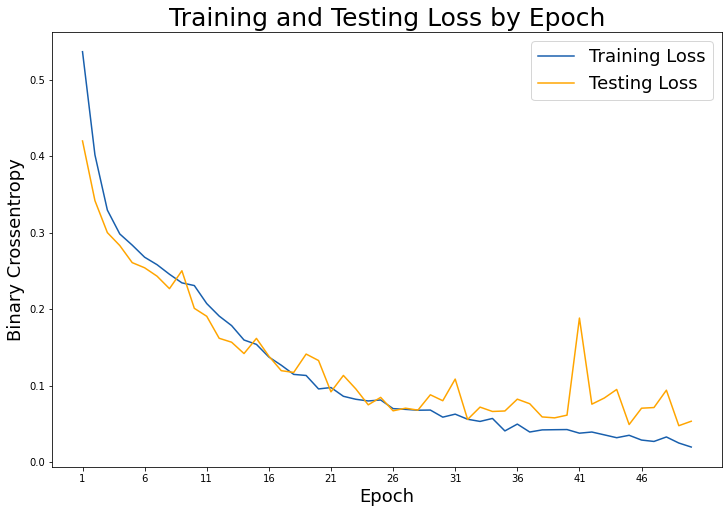

In [ ]:
graph_loss(best_original_model["best_history"])

In [ ]:
train_test_scores = list(zip(best_original_model["train_scores"], best_original_model["test_scores"]))
train_test_scores.sort(key=lambda scores: scores[1])
train_test_scores[-1]

(0.9939106702804565, 0.9858012199401855)